#  MACHINE LEARNING: Portugal Wine. Neural Network and MLR Regression Comparison to model Quality using R,  Caret, and K fold cross-validation

By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | November 22, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]
<hr>

# I Introduction

This project develops Neural Network and Multiple Linear Regression machine learning models to compare both to predict the quality of the wine according to 12 variables that characterize the wine and its quality (score between 1 and 10). 

I use the famous Portugal wine dataset. Two datasets are available of which one dataset is about red wine and have 1599 different varieties and the other is on white wine and have 4898 varieties. I have combined them into one dataset named "wine" and created one additional variable "type" with its categories "1 (white)" and "2 (red)".

All wines are produced in a particular area of Portugal. Data are collected on 12 different properties of the wines one of which is Quality, based on sensory data. Quality is an ordinal variable with a possible ranking from 1 (worst) to 10 (best). Each variety of wine is tasted by three independent tasters and the final rank assigned is the median rank given by the tasters.

Even though the response variable -Quality- is ordinal, in this project it will be assumed to be a continuous variable which is possible to be predicted by the independent predictors, all of which are continuous.

The original data along with detailed description can be found here [ http://archive.ics.uci.edu/ml/datasets/Wine+Quality].

The columns of the "wine" dataset are the variables (features): fixed acidity; volatile acidity; citric acid; residual sugar; chlorides; free sulfur dioxide; total sulfur dioxide; density; pH; sulphates; alcohol; quality. The 13th column is the type of wine observed: white; red.

I consider the original dataset without the variables "density" and "free.sulfor.dioxide". I get rid of them because they could generate a problem of multicollinearity in the process of classification.

The final dataset (df) keep all the register of the original database but replace the upper outliers by its corresponding <i>Threshold</i>.

I consider outliers those points that have any predictor variable value to be outside of the limits constructed by box plots. The following rule is applied:

* A predictor value is considered to be an upper outlier only if it is greater than <b>Threshold = Q3 + 1.5IQR</b>

Application of this rule does not reduces the original datasize becouse it does not eliminate any register.  So, <i>df</i> data size is the same as the original (6497 registers).

The models are developing using Caret library and R, meantime its performances are evaluated using K fold cross-validation, Rsquared and RMSE metrics. I consider 70% and 30% original dataset splitting for the training and testing datasets respectively.

# II Loading the Data

In [117]:
# first remove ALL objects and close all possible connections
closeAllConnections()
rm(list = ls(all = TRUE)) # Does remove all inclusive hidden

# see your memory size
memory.size() 

In [1]:
# install packages and load libraries
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = c("Depends", "Suggests"))
    sapply(pkg, require, character.only = TRUE)
}
# usage
packages <- c("plyr", "dplyr", "leaps", "MASS", "NeuralNetTools", "car", "caret")
ipak(packages)
  

Loading required package: plyr
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: leaps
Warning message:
"package 'leaps' was built under R version 3.4.2"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: NeuralNetTools
Warning message:
"package 'NeuralNetTools' was built under R version 3.4.2"Loading required package: car
Warning message:
"package 'car' was built under R version 3.4.2"
Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

Loading required package: caret
Loading required package: lattice
Loading re

plyr          dplyr          leaps           MASS NeuralNetTools 
          TRUE           TRUE           TRUE           TRUE           TRUE 
           car          caret 
          TRUE           TRUE

In [2]:
# define path location of datasets
wine1.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine2.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

# read datasets
wine1 <- read.csv(wine1.url, header=TRUE, sep=';')
wine2 <- read.csv(wine2.url, header=TRUE, sep=';')

# create dataset base
wine <- rbind(cbind(wine1, type= 1), cbind(wine2, type= 0))

df= subset(wine, select=c('fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides' ,'total.sulfur.dioxide','pH', 'sulphates', 'alcohol', 'quality', 'type'))
attach(df)
head(df)
rm("wine", "wine1", "wine2")

# get some information about the dataset
str(df)


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,type
7.0,0.27,0.36,20.7,0.045,170,3.00,0.45,8.8,6,1
6.3,0.30,0.34,1.6,0.049,132,3.30,0.49,9.5,6,1
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,6,1
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,6,1
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,6,1
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,6,1


'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...
 $ type                : num  1 1 1 1 1 1 1 1 1 1 ...


In [3]:
# verify response variable "type" as factor
#df$type <- as.factor(df$type)
df$quality <- as.numeric(df$quality)

In [4]:
# get some information about the dataset
str(df)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : num  6 6 6 6 6 6 6 6 6 6 ...
 $ type                : num  1 1 1 1 1 1 1 1 1 1 ...


In [5]:
#summarize full dataset by columns 
propmiss <- function(dataframe) {
	m <- sapply(dataframe, function(x) {
		data.frame(
			n=length(!is.na(x)), 
			nmiss=sum(is.na(x)), 
			propmiss=sum(is.na(x))/length(x),
			P25=round(quantile(x, 0.25, na.rm=TRUE),2),
			P75=round(quantile(x, 0.75, na.rm=TRUE),2),            
			IQR=round(IQR(x, na.rm=TRUE),2),
			Threshold= round(quantile(x, 0.75, na.rm=TRUE),2) + 1.5*round(IQR(x, na.rm=TRUE),2),            
			Minimum=round(min(x, na.rm=TRUE),2),
			Median=round(median(x, na.rm=TRUE),2),            
			Maximum=round(max(x, na.rm=TRUE),2),
			Range=round(max(x, na.rm=TRUE)-min(x, na.rm=TRUE),2),
			Mean=round(mean(x, na.rm=TRUE),2),
			StDev=round(sd(x, na.rm=TRUE),2)
		)
	})
	d <- data.frame(t(m))
	d <- sapply(d, unlist)
	d <- as.data.frame(d)
	d$variable <- row.names(d)
	row.names(d) <- NULL
	d <- cbind(d[ncol(d)],d[-ncol(d)])
	return(d[order(d$propmiss), ])
}


In [6]:
# summarize original df dataset
(summary1=propmiss(df[,-c(10:11)])[,-(3:4)])


variable,n,P25,P75,IQR,Threshold,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,6497,6.40,7.70,1.30,9.650,3.80,7.00,15.90,12.10,7.22,1.30
volatile.acidity,6497,0.23,0.40,0.17,0.655,0.08,0.29,1.58,1.50,0.34,0.16
citric.acid,6497,0.25,0.39,0.14,0.600,0.00,0.31,1.66,1.66,0.32,0.15
residual.sugar,6497,1.80,8.10,6.30,17.550,0.60,3.00,65.80,65.20,5.44,4.76
chlorides,6497,0.04,0.06,0.03,0.105,0.01,0.05,0.61,0.60,0.06,0.04
total.sulfur.dioxide,6497,77.00,156.00,79.00,274.500,6.00,118.00,440.00,434.00,115.74,56.52
pH,6497,3.11,3.32,0.21,3.635,2.72,3.21,4.01,1.29,3.22,0.16
sulphates,6497,0.43,0.60,0.17,0.855,0.22,0.51,2.00,1.78,0.53,0.15
alcohol,6497,9.50,11.30,1.80,14.000,8.00,10.30,14.90,6.90,10.49,1.19


In [7]:
# r code to replace outliers by the threshold of each variable
library(mlr)

dfffull <- capLargeValues(df, target = "type",cols = c("fixed.acidity"),threshold = summary1[1,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("volatile.acidity"),threshold = summary1[2,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("citric.acid"),threshold = summary1[3,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("residual.sugar"),threshold = summary1[4,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("chlorides"),threshold = summary1[5,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("total.sulfur.dioxide"),threshold = summary1[6,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("pH"),threshold = summary1[7,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("sulphates"),threshold = summary1[8,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("alcohol"),threshold = summary1[9,6])
unloadNamespace("mlr")


Loading required package: ParamHelpers

Attaching package: 'mlr'

The following object is masked from 'package:caret':

    train



In [8]:
# get some information about the dataset
str(dfffull)


'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : num  6 6 6 6 6 6 6 6 6 6 ...
 $ type                : num  1 1 1 1 1 1 1 1 1 1 ...


In [9]:
# remove and dettach df dataset
rm("df")
detach("df")

# rename dff dataset as df dataset to use the already created R scripts
df <- dfffull

# remove dff dataset
rm("dfffull")

In [10]:
str(df)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : num  6 6 6 6 6 6 6 6 6 6 ...
 $ type                : num  1 1 1 1 1 1 1 1 1 1 ...


# III Getting train and test datasets

In [11]:
#stratified sampling to get the train and test dataset
set.seed(7) # Set Seed so that same sample can be reproduced in future also
# considering response variable as strata
data_part <- createDataPartition(y = df$quality  ,  p = 0.70, list = F)
dftest <- df[-data_part,] # 30% data goes here
dftrain <- df[data_part,] # 70% here


In [12]:
# get some information about training dataset
str(dftrain[,1:11])

'data.frame':	4549 obs. of  11 variables:
 $ fixed.acidity       : num  6.3 7.2 8.1 6.2 7 6.3 8.1 7.9 8.3 6.6 ...
 $ volatile.acidity    : num  0.3 0.23 0.28 0.32 0.27 0.3 0.22 0.18 0.42 0.17 ...
 $ citric.acid         : num  0.34 0.32 0.4 0.16 0.36 0.34 0.43 0.37 0.6 0.38 ...
 $ residual.sugar      : num  1.6 8.5 6.9 7 17.5 ...
 $ chlorides           : num  0.049 0.058 0.05 0.045 0.045 0.049 0.044 0.04 0.04 0.032 ...
 $ total.sulfur.dioxide: num  132 186 97 136 170 132 129 75 172 112 ...
 $ pH                  : num  3.3 3.19 3.26 3.18 3 3.3 3.22 3.18 2.98 3.25 ...
 $ sulphates           : num  0.49 0.4 0.44 0.47 0.45 0.49 0.45 0.63 0.67 0.55 ...
 $ alcohol             : num  9.5 9.9 10.1 9.6 8.8 9.5 11 10.8 9.7 11.4 ...
 $ quality             : num  6 6 6 6 6 6 6 5 5 7 ...
 $ type                : num  1 1 1 1 1 1 1 1 1 1 ...


In [13]:
# get some information about testing dataset
str(dftest[,1:11])

'data.frame':	1948 obs. of  11 variables:
 $ fixed.acidity       : num  7 8.1 7.2 8.1 8.6 6.6 6.2 6.5 6.5 7 ...
 $ volatile.acidity    : num  0.27 0.28 0.23 0.27 0.23 0.16 0.655 0.31 0.39 0.33 ...
 $ citric.acid         : num  0.36 0.4 0.32 0.41 0.4 0.4 0.48 0.14 0.23 0.32 ...
 $ residual.sugar      : num  17.55 6.9 8.5 1.45 4.2 ...
 $ chlorides           : num  0.045 0.05 0.058 0.033 0.035 0.044 0.029 0.044 0.051 0.053 ...
 $ total.sulfur.dioxide: num  170 97 186 63 109 143 75 133 149 138 ...
 $ pH                  : num  3 3.26 3.19 2.99 3.14 3.54 3.33 3.22 3.24 3.13 ...
 $ sulphates           : num  0.45 0.44 0.4 0.56 0.53 0.52 0.39 0.5 0.35 0.28 ...
 $ alcohol             : num  8.8 10.1 9.9 12 9.7 12.4 12.8 9.5 10 11.2 ...
 $ quality             : num  6 6 6 5 5 7 8 5 5 6 ...
 $ type                : num  1 1 1 1 1 1 1 1 1 1 ...


In [14]:
# summarize training dataset
(summary=propmiss(dftrain[,-11])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,4549,6.40,7.70,1.30,3.80,7.00,9.65,5.85,7.15,1.07
volatile.acidity,4549,0.23,0.41,0.18,0.08,0.29,0.66,0.58,0.33,0.15
citric.acid,4549,0.25,0.39,0.14,0.00,0.31,0.60,0.60,0.31,0.13
residual.sugar,4549,1.80,8.10,6.30,0.60,3.00,17.55,16.95,5.39,4.59
chlorides,4549,0.04,0.07,0.03,0.01,0.05,0.10,0.09,0.05,0.02
total.sulfur.dioxide,4549,78.00,156.00,78.00,6.00,118.00,274.50,268.50,115.58,56.52
pH,4549,3.11,3.32,0.21,2.72,3.21,3.63,0.91,3.22,0.16
sulphates,4549,0.43,0.60,0.17,0.22,0.51,0.86,0.64,0.53,0.13
alcohol,4549,9.50,11.30,1.80,8.00,10.30,14.00,6.00,10.49,1.19
quality,4549,5.00,6.00,1.00,3.00,6.00,9.00,6.00,5.82,0.87


In [15]:
# summarize testing dataset
(summary=propmiss(dftest[,-11])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,1948,6.40,7.70,1.30,4.40,7.00,9.65,5.25,7.12,1.06
volatile.acidity,1948,0.23,0.40,0.17,0.10,0.29,0.66,0.56,0.33,0.14
citric.acid,1948,0.24,0.39,0.15,0.00,0.31,0.60,0.60,0.32,0.13
residual.sugar,1948,1.80,8.03,6.23,0.70,3.10,17.55,16.85,5.46,4.66
chlorides,1948,0.04,0.06,0.03,0.01,0.05,0.10,0.10,0.05,0.02
total.sulfur.dioxide,1948,77.00,156.00,79.00,8.00,119.00,274.50,266.50,115.90,55.66
pH,1948,3.11,3.33,0.22,2.79,3.21,3.63,0.84,3.22,0.16
sulphates,1948,0.43,0.60,0.17,0.26,0.50,0.86,0.60,0.53,0.13
alcohol,1948,9.50,11.40,1.90,8.40,10.30,14.00,5.60,10.49,1.21
quality,1948,5.00,6.00,1.00,3.00,6.00,9.00,6.00,5.82,0.88


# IV Modeling
 
In this project, I have considered Neural Network (nnet library) and Multiple Linear Regression (MLR) algorithm both running under Caret library. I use set.seed(123) so that same sample can be reproduced in the future and also it ensures the results are directly comparable.

## 41 Neural Network Model

In [12]:
## Control Resampling Technique: 10-fold CV
fiveStats = function(...) c (twoClassSummary(...), defaultSummary(...))
metric <- "Rsquared" 
cvCtrl <- trainControl(method = "cv", number=10,  classProbs = FALSE, savePredictions=T)


In [13]:
## Construction Predictive Model1
set.seed(123)
model <- train(quality ~ ., data = dftrain, method='nnet', trControl=cvCtrl, metric= metric, linout=TRUE, preProcess="range", tuneLength=3, trace=F, maxit=1000)


Loading required package: nnet
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

In [14]:
#model results
model

Neural Network 

4549 samples
  10 predictor

Pre-processing: re-scaling to [0, 1] (10) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4093, 4094, 4094, 4095, 4095, 4094, ... 
Resampling results across tuning parameters:

  size  decay  RMSE       Rsquared 
  1     0e+00  0.7722158  0.2361337
  1     1e-04  0.7484562  0.2644715
  1     1e-01  0.7370310  0.2859449
  3     0e+00  0.7422932  0.2734277
  3     1e-04  0.7252900  0.3083340
  3     1e-01  0.7195952  0.3193067
  5     0e+00  0.7390654  0.3108791
  5     1e-04  0.7341000  0.2902164
  5     1e-01  0.7075072  0.3421134

Rsquared was used to select the optimal model using  the largest value.
The final values used for the model were size = 5 and decay = 0.1.

Final metrics for the model

Hidden layers (size): 5<br>
Decay: 0.1<br>
RMSE: 0.7075072<br>
Rsquared: 0.3421134

In [77]:
## variable importance model1
nn.imp1 = varImp ( model , scale = T)
nn.imp1

nnet variable importance

                     Overall
type                 100.000
total.sulfur.dioxide  98.363
volatile.acidity      86.426
alcohol               74.172
pH                    51.620
residual.sugar        45.826
chlorides             25.928
fixed.acidity         11.493
sulphates              8.034
citric.acid            0.000

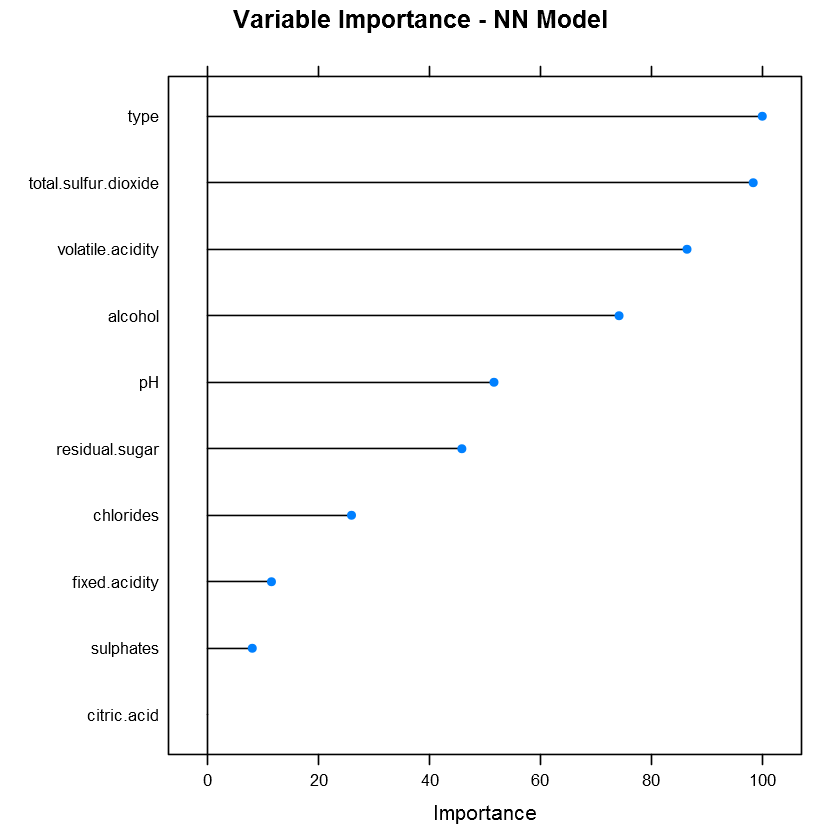

In [78]:
## Graphic variable importance model1
# dev.new()
plot(nn.imp1, top=10, main="Variable Importance - NN Model")


I re-run the model without the less important predictor (citric.acid), and I got RMSE: 0.7088838  and Rsquared: 0.3391035 both smaller than the ones got it with the full model that considered citric.acid as one of its predictors. So, I decided to keep the model the way it was before.

In [80]:
summary(model)

a 10-5-1 network with 61 weights
options were - linear output units  decay=0.1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   0.34   -0.66   -1.94   -0.37    1.85    0.16   -0.33    1.05   -0.04    1.80 
i10->h1 
  -4.85 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  -0.86   -0.17    0.56    0.16    0.77   -1.07   -6.96    1.84   -2.30    0.15 
i10->h2 
   0.12 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
   0.40    1.19    3.23    0.54   -2.81   -1.33   -2.81   -2.23    0.30   -0.90 
i10->h3 
   4.48 
  b->h4  i1->h4  i2->h4  i3->h4  i4->h4  i5->h4  i6->h4  i7->h4  i8->h4  i9->h4 
  -4.86   -1.03   -1.31    0.39    1.25   -1.29   -0.72    2.07   -0.16    4.18 
i10->h4 
   3.27 
  b->h5  i1->h5  i2->h5  i3->h5  i4->h5  i5->h5  i6->h5  i7->h5  i8->h5  i9->h5 
  -2.60    0.93   -6.64   -1.28    1.10    2.00    2.67   -1.15    0.37   -4.32 
i10->h5 
   0.61 
 b->o h1->o h2->o h3-

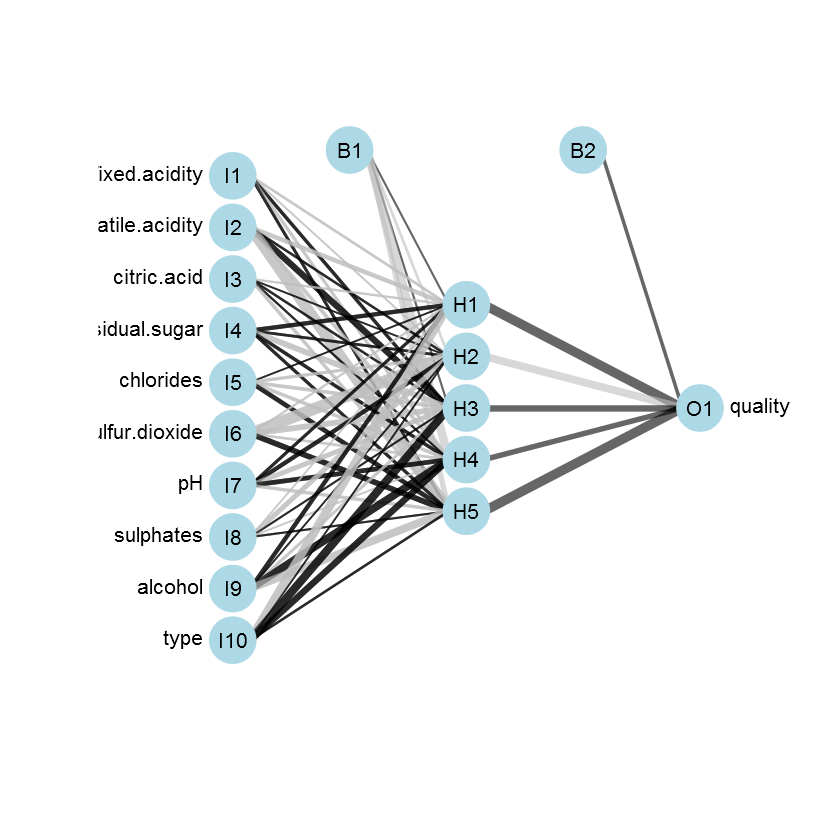

In [81]:
## Creating the nn plot
plotnet(model, alpha=0.6)

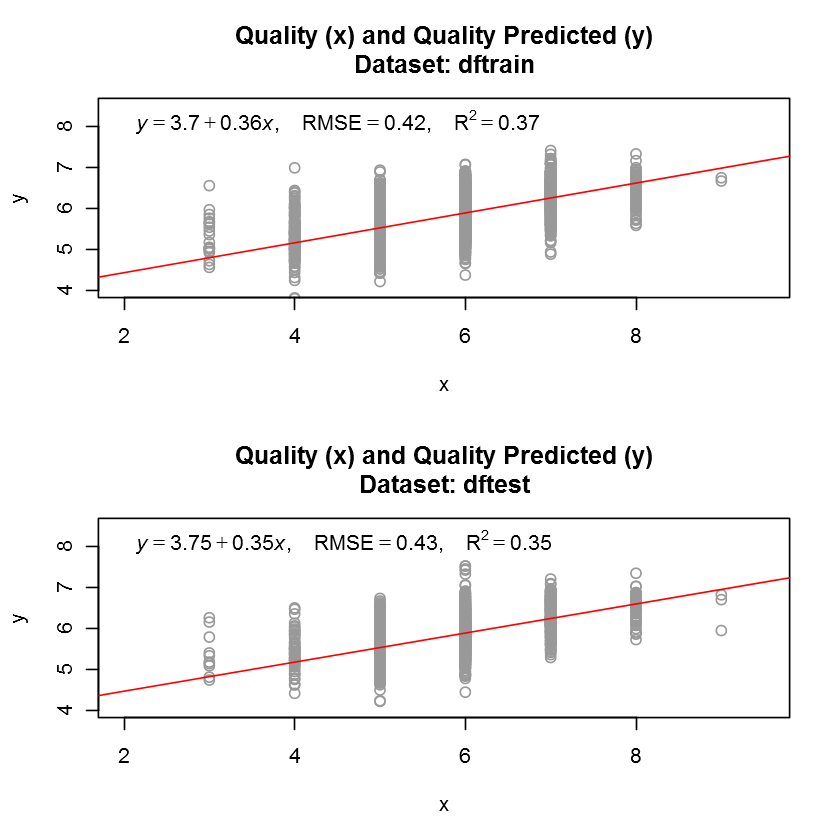

In [15]:
#Graphical examination of results
old<-par(mfrow=c(1,1))
par(mfrow=c(2,1))

#Examine results on dftrain dataset -------------------------------------------------------------------------------
pstest <- predict(model, dftrain)
#head(pstest)

## Getting data to make plot -quality v/s quality estimated on dftrain dataset-
plot.fit.train<-data.frame(dftrain$quality, pstest)

# head(plot.fit.train)

## Creating plot quality v/s quality estimated
x<-dftrain$quality
y<-pstest
fit <- lm(y ~ x, data = plot.fit.train)


## Calculate RMSE and other values
rmse <- round(sqrt(mean(resid(fit)^2)), 2)
coefs <- coef(fit)
b0 <- round(coefs[1], 2)
b1 <- round(coefs[2],2)
r2 <- round(summary(fit)$r.squared, 2)

eqn <- bquote(italic(y) == .(b0) + .(b1)*italic(x) * ",  " ~~ 
                RMSE == .(rmse)* ",  " ~~ R^2 == .(r2))

## Plotting
plot( x, y, main= "Quality (x) and Quality Predicted (y)\nDataset: dftrain", col="gray60", xlim=c(2,9.5), ylim=c(4,8.5))
abline(fit, col = "red")
text(2, 8, eqn, pos = 4)


#Examine results on dftest dataset -------------------------------------------------------------------------------
pstest <- predict(model, dftest)
#head(pstest)

## Getting data to make plot -quality v/s quality estimated on dftest dataset-
plot.fit.test<-data.frame(dftest$quality, pstest)

# head(plot.fit.test)

## Creating plot quality v/s quality estimated
x<-dftest$quality
y<-pstest
fit2 <- lm(y ~ x, data = plot.fit.test)


## Calculate RMSE and other values
rmse <- round(sqrt(mean(resid(fit2)^2)), 2)
coefs <- coef(fit2)
b0 <- round(coefs[1], 2)
b1 <- round(coefs[2],2)
r2 <- round(summary(fit2)$r.squared, 2)

eqn <- bquote(italic(y) == .(b0) + .(b1)*italic(x) * ",  " ~~ 
                RMSE == .(rmse)* ",  " ~~ R^2 == .(r2))


## Plotting
plot1<-plot( x, y, main= "Quality (x) and Quality Predicted (y)\nDataset: dftest", col="gray60", xlim=c(2,9.5), ylim=c(4,8.5))
abline(fit2, col = "red")
text(2, 8, eqn, pos = 4)
par(old)

## 42 Multiple Linear Regression (MLR) Model

The equation of the regression model used here corresponds to the one selected in section 41 of project 10, which you [can access here](https://github.com/arqmain/Machine_Learning/blob/master/R_MLearning/PWine_Quality_MLR_KFold/Project10_Portugal_WINE_MRegression.ipynb).

In [16]:
## Control Resampling Technique: 10-fold CV
#fiveStats = function(...) c (twoClassSummary(...), defaultSummary(...))
fiveStats = function(...) c (defaultSummary(...))
cvCtrl <- trainControl(method = "cv", number=10,  summaryFunction = fiveStats, classProbs = FALSE, savePredictions=T)

In [17]:
## Construction Predictive Model
set.seed(123)
formula <- as.formula("quality ~ volatile.acidity + residual.sugar + chlorides + total.sulfur.dioxide + pH + sulphates + alcohol")
mlrmodel <- train(formula, data=dftrain, method="lm",   trControl = cvCtrl, metric="Rsquared")


In [18]:
# Getting summary of fitted model2
summary(mlrmodel)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4468 -0.4592 -0.0417  0.4682  2.7437 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.9295104  0.2815898   6.852 8.25e-12 ***
volatile.acidity     -1.5406579  0.0941841 -16.358  < 2e-16 ***
residual.sugar        0.0219277  0.0029314   7.480 8.85e-14 ***
chlorides            -1.4634985  0.7330817  -1.996 0.045954 *  
total.sulfur.dioxide -0.0009527  0.0002605  -3.657 0.000258 ***
pH                    0.1819421  0.0750515   2.424 0.015380 *  
sulphates             0.7704683  0.0939626   8.200 3.11e-16 ***
alcohol               0.3317706  0.0114870  28.882  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7389 on 4541 degrees of freedom
Multiple R-squared:  0.2821,	Adjusted R-squared:  0.281 
F-statistic: 254.9 on 7 and 4541 DF,  p-value: < 2.2e-16


In [19]:
## train results model2
mlrmodel

Linear Regression 

4549 samples
   7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4093, 4094, 4094, 4095, 4095, 4094, ... 
Resampling results:

  RMSE       Rsquared 
  0.7392432  0.2816517

Tuning parameter 'intercept' was held constant at a value of TRUE

In [22]:
# variable importance mlrmodel
mlr.imp = varImp (mlrmodel , scale = T )
mlr.imp 

lm variable importance

                     Overall
alcohol              100.000
volatile.acidity      53.417
sulphates             23.073
residual.sugar        20.397
total.sulfur.dioxide   6.178
pH                     1.591
chlorides              0.000

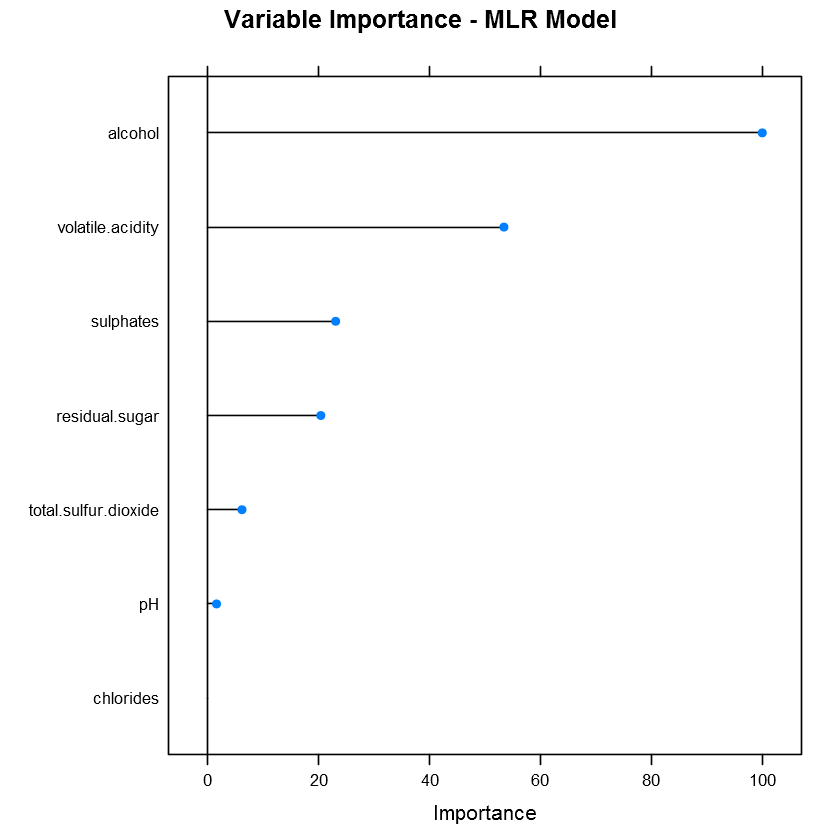

In [23]:
## Graphic variable importance model2
# dev.new()
plot(mlr.imp, top=7, main="Variable Importance - MLR Model")

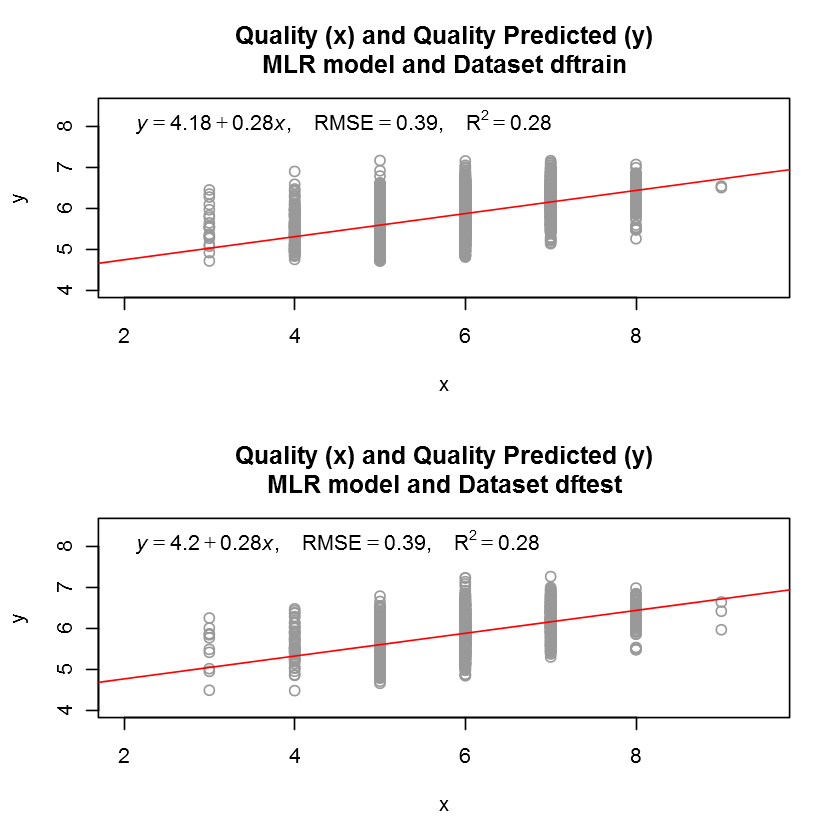

In [20]:
#Graphical examination of results
old<-par(mfrow=c(1,1))
par(mfrow=c(2,1))

#Examine results on dftrain dataset -------------------------------------------------------------------------------
ps<-predict(mlrmodel,dftrain)
#head(pstest)

## Getting data to make plot -quality v/s quality estimated on dftrain dataset-
plot.fit.train<-data.frame(dftrain$quality, ps)

# head(plot.fit.train)

## Creating plot quality v/s quality estimated
x<-dftrain$quality
y<-ps
fit <- lm(y ~ x, data = plot.fit.train)


## Calculate RMSE and other values
rmse <- round(sqrt(mean(resid(fit)^2)), 2)
coefs <- coef(fit)
b0 <- round(coefs[1], 2)
b1 <- round(coefs[2],2)
r2 <- round(summary(fit)$r.squared, 2)

eqn <- bquote(italic(y) == .(b0) + .(b1)*italic(x) * ",  " ~~ 
                RMSE == .(rmse)* ",  " ~~ R^2 == .(r2))

## Plotting
plot( x, y, main= "Quality (x) and Quality Predicted (y)\nMLR model and Dataset dftrain", col="gray60", xlim=c(2,9.5), ylim=c(4,8.5))
abline(fit, col = "red")
text(2, 8, eqn, pos = 4)


#Examine results on dftest dataset -------------------------------------------------------------------------------
pstest <- predict(mlrmodel, dftest)
#head(pstest)

## Getting data to make plot -quality v/s quality estimated on dftest dataset-
plot.fit.test<-data.frame(dftest$quality, pstest)

# head(plot.fit.test)

## Creating plot quality v/s quality estimated
x<-dftest$quality
y<-pstest
fit2 <- lm(y ~ x, data = plot.fit.test)


## Calculate RMSE and other values
rmse <- round(sqrt(mean(resid(fit2)^2)), 2)
coefs <- coef(fit2)
b0 <- round(coefs[1], 2)
b1 <- round(coefs[2],2)
r2 <- round(summary(fit2)$r.squared, 2)

eqn <- bquote(italic(y) == .(b0) + .(b1)*italic(x) * ",  " ~~ 
                RMSE == .(rmse)* ",  " ~~ R^2 == .(r2))


## Plotting
plot1<-plot( x, y, main= "Quality (x) and Quality Predicted (y)\nMLR model and Dataset dftest", col="gray60", xlim=c(2,9.5), ylim=c(4,8.5))
abline(fit2, col = "red")
text(2, 8, eqn, pos = 4)
par(old)

# V Model's Comparison

The following table presents a resume of the two models presented above: nnKFold and mlrKFold.


<table align="left">
  <thead>
  <tr>
    <th >Model</th>
    <th >Database</th>
    <th>RMSE</th>
        <th>Rsquared</th>
        
  </tr>
    </thead>
      <tbody>
  <tr>
    <td>nnKFold <br> mlrKFold</td>
        <td>dftrain<br>dftrain</td>
    <td>0.71 (+) <br>0.74 (+)</td>
        <td>0.34 (+) <br>0.28 (+)</td>
  </tr>
  <tr>
    <td>nnKFold <br> mlrKFold</td>
        <td>dftrain <br> dftrain</td>
    <td>0.42 (++) <br> 0.39 (++)</td>
        <td>0.37 (++) <br>0.28 (++)</td>

  </tr>
<tr>
    <td>nnKFold <br> mlrKFold</td>
        <td>dftest <br> dftest</td>
    <td>0.43 (+++) <br> 0.39 (+++)</td>
        <td>0.35 (+++) <br>0.28 (+++)</td>

  </tr>
 
   </tbody>
</table>

(+): Metric got as an average throughout of 10 folds.<br>
(++): Metric got from fit <- lm(y ~ x) on dftrain where "y: estimated quality" and "x: real quality".<br>
(+++): Metric got from fit <- lm(y ~ x) on dftest where "y: estimated quality" and "x: real quality". 

As we can see from the table above nnKFold regression model is better than mlrKFold.  The metrics that are really important are the (+) ones.

## VI Conclusion

As a general conclusion for this dataset, we can say that it does not look like wine quality is well linearly supported by its chemical properties.  Both linear regression models tried here -nnKFold and mlrKFold- shows very bad performance metrics and call us to wake up and move on from the linear basic supposition to model the wine quality.  

Anyway, making the line for the sum we see that the algorithm nnKFold behaves better to model the quality of the wines with the characteristics present in this famous Portugal dataset.

In any case, we must remember that the MLR model has not been corrected yet for its problems of homoscedasticity, normality, and dependence from which it suffers. Maybe, once those corrections are made, their behavior improves and will eventually surpass nnKFold.

In the meantime, we will consider it worthwhile to note that if we want to model the quality of wine as a function of the variables present in this dataset, both algorithms show us that it is not a good idea to assume a linear function to bind the predictor variables with the quality. That is, "even when the monkey dresses in silk, monkey stays".

Finally, it remains to be done to try to model the type of wine separately with MLR and NN. That is, one MLR and NN model for white wine and another for red wine. I leave it up to the reader to do this and compare the results with the joint model discussed in this project.

<hr>
By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | November 22, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]